# DistilBERT Model Training and Evaluation

## 0 - Import require Packages and Functions

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from utils import preprocess_text, TextDataset

## 1- Loading, Preprocessing and Splitting the data into Training / Validation / Test sets (70/15/15)

In [9]:
text_df = pd.read_csv("./df_file.csv") #./df_file.csv, /content/drive/MyDrive/df_file.csv

texts = text_df['Text'].to_list()
labels = text_df['Label'].to_list()

# Preprocess your texts here
preprocessed_texts = [preprocess_text(text) for text in texts]

# Split into train and remaining (validation + test)
train_texts, remaining_texts, train_labels, remaining_labels = train_test_split(
    preprocessed_texts, labels, test_size=0.3, random_state=43, stratify=labels)

# Split the remaining data equally into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    remaining_texts, remaining_labels, test_size=0.5, random_state=43, stratify=remaining_labels)

#from transformers import set_seed

#set_seed(42)

## 2 - Tokenizing the data and Training the DistilBERT Model

In [6]:
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Encode the text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Create the dataset objects
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Load the DistilBert model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Define the training arguments
training_args = TrainingArguments(
    #output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    #logging_dir='./logs',            # directory for storing logs
    #logging_steps=10,
    seed=42
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 294/294 [2:15:23<00:00, 27.63s/it]  

{'train_runtime': 8123.6353, 'train_samples_per_second': 0.575, 'train_steps_per_second': 0.036, 'train_loss': 0.6275762441206951, 'epoch': 3.0}


TrainOutput(global_step=294, training_loss=0.6275762441206951, metrics={'train_runtime': 8123.6353, 'train_samples_per_second': 0.575, 'train_steps_per_second': 0.036, 'total_flos': 618788322984960.0, 'train_loss': 0.6275762441206951, 'epoch': 3.0})

## 3 - Saving the Trained Tokenizer and Model for future use

In [7]:
# Save the model and tokenizer to a directory
model.save_pretrained('..\Models\my_distilbert_model')
tokenizer.save_pretrained('..\Models\my_distilbert_tokenizer')

('..\\Models\\my_distilbert_tokenizer\\tokenizer_config.json',
 '..\\Models\\my_distilbert_tokenizer\\special_tokens_map.json',
 '..\\Models\\my_distilbert_tokenizer\\vocab.txt',
 '..\\Models\\my_distilbert_tokenizer\\added_tokens.json')

## 4 - Evaluating the Model using the Test data

In [10]:
# test_df = pd.read_csv("./TestDataUnseen.csv", delimiter=';') #./df_file.csv, /content/drive/MyDrive/df_file.csv

# texts = test_df['Text'].to_list()
# test_labels = test_df['Label'].to_list()

# test_texts = [preprocess_text(text) for text in texts]

# Load the model and tokenizer from the saved directory
model = DistilBertForSequenceClassification.from_pretrained('..\Models\my_distilbert_model')
tokenizer = DistilBertTokenizer.from_pretrained('..\Models\my_distilbert_tokenizer')

test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = TextDataset(test_encodings, test_labels)

# Load the data into a DataLoader for batch processing
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Initialize a list to store predictions
predictions = []

# Disable gradient calculations for efficiency
with torch.no_grad():
    for batch in test_loader:
        # Forward pass, get the logits
        outputs = model(**batch)
        logits = outputs.logits
        
        # Convert logits to probabilities
        probs = torch.nn.functional.softmax(logits, dim=1)
        
        # Get the predicted class labels
        preds = torch.argmax(probs, dim=1)
        
        # Store the predictions
        predictions.extend(preds.tolist())

report = classification_report(test_labels, predictions) 
print(report)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        63
           1       0.97      1.00      0.99        77
           2       1.00      0.93      0.97        60
           3       0.98      0.98      0.98        58
           4       0.97      0.92      0.95        76

    accuracy                           0.97       334
   macro avg       0.97      0.97      0.97       334
weighted avg       0.97      0.97      0.97       334



In [13]:
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy on Test Set:", accuracy)

Accuracy on Test Set: 0.9670658682634731


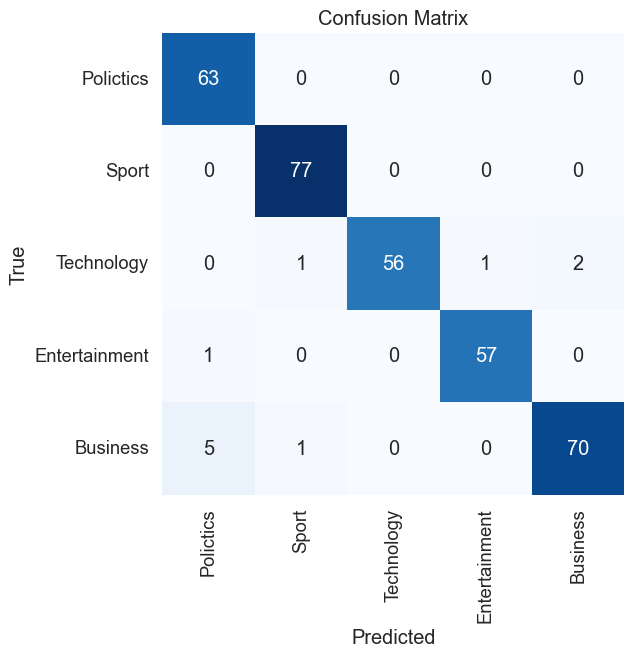

In [11]:
confusion = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
xticklabels=["Polictics", "Sport", "Technology", "Entertainment", "Business"], yticklabels=["Polictics", "Sport", "Technology", "Entertainment", "Business"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()